# LungsNet: Data Acquisition & Exploration
This notebook handles downloading the Chest X-Ray dataset and initial exploration.

In [16]:
import os
import zipfile
import matplotlib.pyplot as plt
import cv2
from glob import glob
import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import shutil
import gc
import uuid

## 1. Setup Kaggle & Download Data
Ensure `kaggle.json` is in `C:\Users\VICTUS\.kaggle\` or set the environment variables.

In [17]:
# Install kaggle if not already installed
# !pip install kaggle

# Authenticate (Assuming kaggle.json is in standard location or env vars set)
# If you have kaggle.json in the project root, move it:
if os.path.exists("../kaggle.json"):
    os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
    os.rename("../kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))

# Download dataset
dataset_name = "paultimothymooney/chest-xray-pneumonia"
download_dir = "../data/raw"

if not os.path.exists(download_dir):
    os.makedirs(download_dir)
    print(f"Downloading {dataset_name}...")
    !kaggle datasets download -d {dataset_name} -p {download_dir} --unzip
else:
    print("Data directory already exists. Skipping download.")

Data directory already exists. Skipping download.


## 2. Visualize Data Distribution

Train NORMAL: 1342
Train PNEUMONIA: 3876


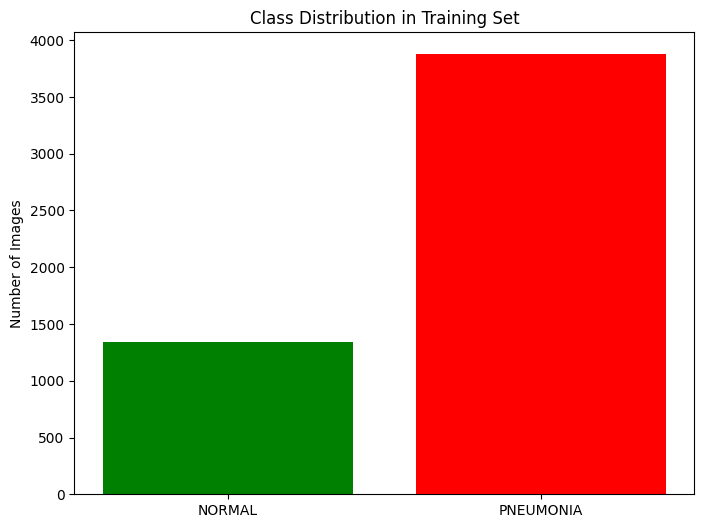

In [18]:
data_dir = "../data/raw/chest_xray"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")
val_dir = os.path.join(data_dir, "val")

categories = ["NORMAL", "PNEUMONIA"]

for category in categories:
    train_count = len(os.listdir(os.path.join(train_dir, category)))
    print(f"Train {category}: {train_count}")

data = {
    'Class': categories,
    'Count': [len(os.listdir(os.path.join(train_dir, cat))) for cat in categories]
}

plt.figure(figsize=(8, 6))
plt.bar(data['Class'], data['Count'], color=['green', 'red'])
plt.title('Class Distribution in Training Set')
plt.ylabel('Number of Images')
plt.show()

## 3. Feature Extraction & Visualization (t-SNE)
To understand how distinguishable the classes are, we use a pre-trained CNN (DenseNet121) to extract image features and visualize them in 2D using t-SNE.

Loading pre-trained DenseNet121 model...
Extracting features from 600 images...
Skipping .DS_Store: cannot identify image file <_io.BytesIO object at 0x000001C484F9C130>
Feature matrix shape: (599, 1024)
Running t-SNE... (this may take a few moments)


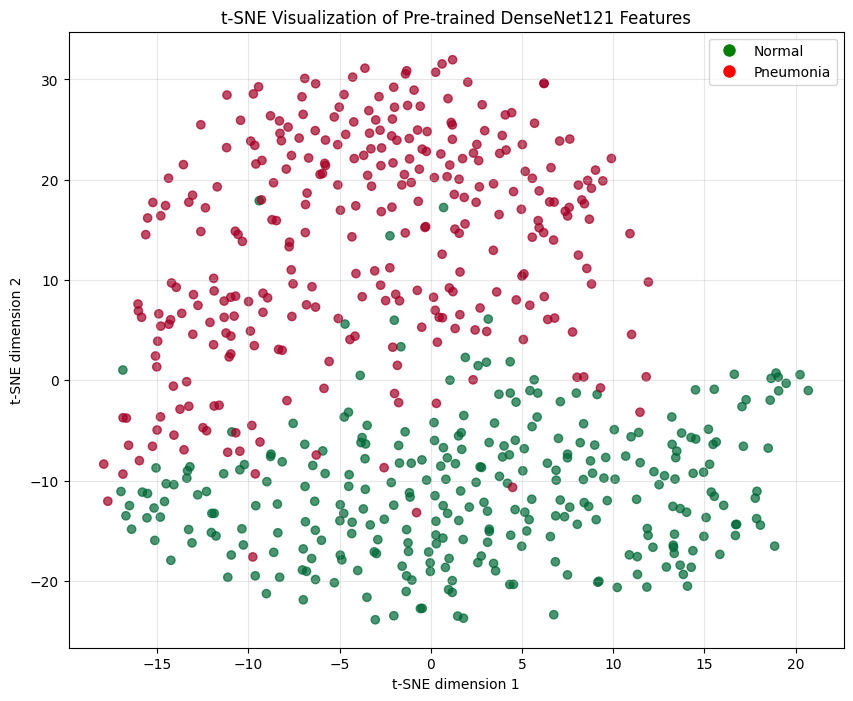

In [19]:
# 1. Load Pre-trained Model (Feature Extractor)
# We use DenseNet121 with ImageNet weights, excluding the top classification layer.
print("Loading pre-trained DenseNet121 model...")
base_model = DenseNet121(
    weights='imagenet',
    include_top=False,
    pooling='avg'  # Global Average Pooling to get a 1024-d vector
)

# 2. Sample Data (Process a subset to save time and memory)
SAMPLE_SIZE = 300 # Number of images per class to sample
features = []
labels = []

print(f"Extracting features from {SAMPLE_SIZE * 2} images...")

for label_code, category in enumerate(categories):
    class_dir = os.path.join(train_dir, category)
    image_files = os.listdir(class_dir)
    
    # Randomly sample images
    sampled_files = np.random.choice(image_files, min(len(image_files), SAMPLE_SIZE), replace=False)
    
    for file_name in sampled_files:
        img_path = os.path.join(class_dir, file_name)
        try:
            # Preprocess image
            img = load_img(img_path, target_size=(224, 224))
            x = img_to_array(img)
            x = np.expand_dims(x, axis=0)
            x = preprocess_input(x)
            
            # Extract deep features
            feat = base_model.predict(x, verbose=0)
            features.append(feat.flatten())
            labels.append(label_code)
        except Exception as e:
            print(f"Skipping {file_name}: {e}")

features = np.array(features)
labels = np.array(labels)

print(f"Feature matrix shape: {features.shape}")

# 3. Run t-SNE (Dimensionality Reduction)
print("Running t-SNE... (this may take a few moments)")
tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto')
tsne_results = tsne.fit_transform(features)

# 4. Plot Results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    tsne_results[:, 0], tsne_results[:, 1],
    c=labels,
    cmap='RdYlGn_r', # Red for Pneumonia (1), Green for Normal (0)
    alpha=0.7
)

# Custom legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='green', label='Normal', markersize=10),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', label='Pneumonia', markersize=10)
]
plt.legend(handles=legend_elements, loc="best")
plt.title('t-SNE Visualization of Pre-trained DenseNet121 Features')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.grid(True, alpha=0.3)
plt.show()

## 4. Handling Imbalance: Offline Augmentation
As observed, the dataset is **imbalanced** (Normal: ~1300 vs Pneumonia: ~3800).
We will create a new dataset directory `../data/balanced` where we **augment the Normal class** to match the Pneumonia class count.

**Technique:** Offline Augmentation (creating physical files)
**Goal:** ~3876 images for both classes.

In [20]:
# --- Robust Augmentation Script ---
# This script ensures the target count is reached by checking actual files and retrying if needed.

RAW_TRAIN_DIR = "../data/raw/chest_xray/train"
BALANCED_TRAIN_DIR = "../data/balanced/train"
TARGET_COUNT = 3876
categories = ["NORMAL", "PNEUMONIA"]

# 1. Setup Balanced Directory (If keeping previous work, this just checks/fills)
if not os.path.exists(BALANCED_TRAIN_DIR):
    print("Creating balanced dataset directory...")
    os.makedirs(BALANCED_TRAIN_DIR)
    for category in categories:
        src = os.path.join(RAW_TRAIN_DIR, category)
        dst = os.path.join(BALANCED_TRAIN_DIR, category)
        if not os.path.exists(dst):
            shutil.copytree(src, dst)
        print(f"Copied original {category} images.")
else:
    print("Balanced directory detected. Checking content...")

# 2. Augmentation Config
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    fill_mode='nearest'
)

# 3. Robust Generation Loop
normal_dir = os.path.join(BALANCED_TRAIN_DIR, "NORMAL")
MAX_LOOPS = 5 # Prevent infinite loops
loop_count = 0

print(f"Target per class: {TARGET_COUNT}")

while loop_count < MAX_LOOPS:
    # Count ACTUAL valid files on disk
    valid_files = [f for f in os.listdir(normal_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    current_count = len(valid_files)
    delta = TARGET_COUNT - current_count
    
    if delta <= 0:
        print(f"Target reached! Total NORMAL images: {current_count}")
        break
        
    print(f"\n>>> Loop {loop_count+1}: Short by {delta} images. Generating...")
    
    # Generate slightly more than delta to account for rare save failures
    target_gen = delta + 20 
    generated = 0
    i = 0
    
    # Unique prefix for this batch to prevent filename collisions
    batch_prefix = f"aug_loop{loop_count}_{uuid.uuid4().hex[:4]}"
    
    while generated < target_gen:
        if not valid_files:
            print("Error: No source images found!")
            loop_count = MAX_LOOPS
            break
            
        img_name = valid_files[i % len(valid_files)]
        img_path = os.path.join(normal_dir, img_name)
        
        try:
            # Optimization: Resize to 224x224 directly on load
            img = load_img(img_path, target_size=(224, 224))
            x = img_to_array(img)
            x = x.reshape((1,) + x.shape)
            
            for batch in datagen.flow(x, batch_size=1, 
                                      save_to_dir=normal_dir, 
                                      save_prefix=batch_prefix, 
                                      save_format='jpeg'):
                generated += 1
                break 
                
            # Explicit cleanup
            del img, x
            if generated % 100 == 0: 
                gc.collect()
                
        except Exception as e:
            # Silent fail for individual bad files, keep moving
            pass
            
        i += 1
        if generated % 200 == 0 and generated > 0:
            print(f"  Generated {generated}/{target_gen}...")
    
    # Loop finished, force garbage collection
    gc.collect()
    loop_count += 1
    
print("Augmentation process finished.")

Balanced directory detected. Checking content...
Target per class: 3876

>>> Loop 1: Short by 312 images. Generating...
  Generated 200/332...
Target reached! Total NORMAL images: 3892
Augmentation process finished.


## 5. Verify Balanced Distribution

NORMAL: 3893
PNEUMONIA: 3876


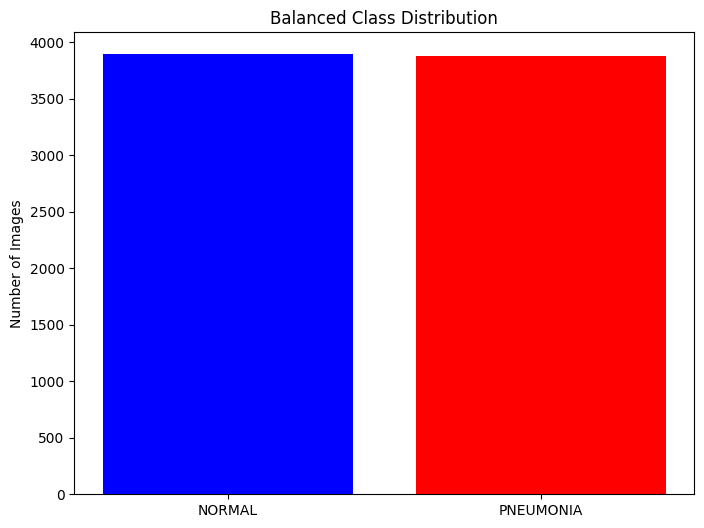

In [21]:
categories = ["NORMAL", "PNEUMONIA"]
counts = []

for category in categories:
    path = os.path.join(BALANCED_TRAIN_DIR, category)
    if os.path.exists(path):
        counts.append(len(os.listdir(path)))
    else:
        counts.append(0)
    print(f"{category}: {counts[-1]}")

plt.figure(figsize=(8, 6))
plt.bar(categories, counts, color=['blue', 'red'])
plt.title('Balanced Class Distribution')
plt.ylabel('Number of Images')
plt.show()

## 6. Visual Inspection of Balanced Data

Visualizing samples from Balanced Dataset...


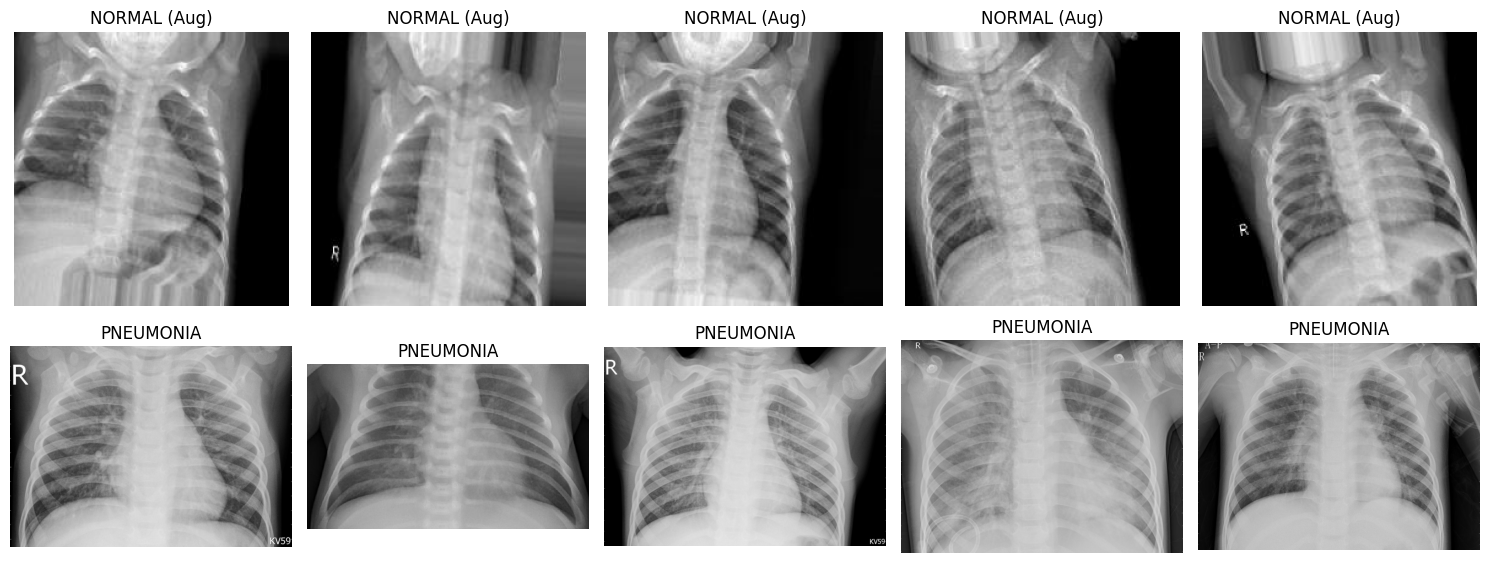

In [22]:
def plot_balanced_samples(base_dir, n=5):
    fig, axes = plt.subplots(2, n, figsize=(15, 6))
    
    # 1. NORMAL (Prioritize Augmented)
    normal_dir = os.path.join(base_dir, "NORMAL")
    all_normal = os.listdir(normal_dir)
    # Filter for augmented images first
    aug_normal = [f for f in all_normal if 'aug' in f]
    # If not enough augmented, mix with original
    if len(aug_normal) < n:
        candidates = all_normal
    else:
        candidates = aug_normal
        
    selected_normal = np.random.choice(candidates, n, replace=False)
    
    for i, img_name in enumerate(selected_normal):
        img_path = os.path.join(normal_dir, img_name)
        try:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[0, i].imshow(img, cmap='gray')
            title = "NORMAL (Aug)" if 'aug' in img_name else "NORMAL (Orig)"
            axes[0, i].set_title(title)
            axes[0, i].axis('off')
        except Exception as e:
            print(f"Error loading {img_name}: {e}")

    # 2. PNEUMONIA
    pneu_dir = os.path.join(base_dir, "PNEUMONIA")
    all_pneu = os.listdir(pneu_dir)
    selected_pneu = np.random.choice(all_pneu, n, replace=False)
    
    for i, img_name in enumerate(selected_pneu):
        img_path = os.path.join(pneu_dir, img_name)
        try:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[1, i].imshow(img, cmap='gray')
            axes[1, i].set_title("PNEUMONIA")
            axes[1, i].axis('off')
        except Exception as e:
            print(f"Error loading {img_name}: {e}")
            
    plt.tight_layout()
    plt.show()

print("Visualizing samples from Balanced Dataset...")
plot_balanced_samples(BALANCED_TRAIN_DIR, n=5)